In [1]:
#organize web scraping data into groups
#probably receive data in csv
#name price'
#bread
#muffin bread 

#how do we group the breads into groups 
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [1]:
#as a test, I will fabricate the clusters by choosing specific categories 
# in this dataset we will have three categories ( Muffins, Bread, and Cookies)
corpus = ['Thomas Original Nooks and Crannies English Muffins',
        "Jiffy Corn Muffin Mix",
        "Bakery Fresh Goodness Blueberry Muffins",
        "Blueberry Muffin Mix",
        "Honey Cornbread and Muffin Mix",
        'Kroger® Round Top White Bread',
        'Kroger® Enriched White Sandwich Bread',
        'Natures Own Honey Wheat Bread',
        'Oroweat Country White Bread',
        'Western Hearth 12 Grain Bread',
        "Wonder Classic White Bread"
        'Daves Killer Bread 21 Whole Grains',
        "Bakery Fresh Goodness Chocolate Chip Cookies",
        "Chocolate Chip Cookie Dough"
        "Cinnamon Swirl Bread" 
        ]

In [3]:
#removing stop words. (Brands)
def remove_stop(corpus):  
    stop_words = ['Thomas',"Kings","Bakery","Fresh","Daves","Natures","Kroger®","Goodness","Killer","and"]
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    
    return results


In [4]:
corpus = remove_stop(corpus)
print(corpus)

['Original Nooks Crannies English Muffins', 'Chocolate Chip Cookies', 'Plain Bagels', 'Hawaiian Sweet Mini Sub Rolls 6ct', 'Plain Angel Food Cake', 'Blue Frosted Sugar Cookies', 'Round Top White Bread', 'Enriched White Sandwich Bread', 'Own Honey Wheat Bread', 'Oroweat Country White Bread', 'Western Hearth 12 Grain Bread', 'Bread 21 Whole Grains']


from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])        
X = pipeline.fit_transform(items).todense()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1])
plt.show() 

In [5]:
#get the words we want to train
words = []
for text in corpus:
    for word in text.split(' '):
        words.append(word)
words = set(words)
        

In [6]:
print(words)

{'Frosted', 'Country', 'Bread', 'Cake', 'Western', 'Cookies', 'Original', 'Round', 'Grains', 'Mini', 'Bagels', 'White', 'Blue', 'Sweet', 'Rolls', 'Oroweat', 'Top', 'Chocolate', 'Honey', 'Hearth', 'Sandwich', 'English', 'Nooks', 'Food', 'Grain', '12', 'Wheat', 'Enriched', 'Plain', '6ct', '21', 'Sugar', 'Hawaiian', 'Chip', 'Angel', 'Sub', 'Whole', 'Own', 'Crannies', 'Muffins'}


In [7]:
word2int = {}

for i, word in enumerate(words):
    word2int[word] = i

sentences = []
for sentence in corpus:
    sentences.append(sentence.split())

WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx-WINDOW_SIZE,0) : min(idx+WINDOW_SIZE,len(sentence))]:
            if neighbor != word:
                data.append([word,neighbor])

In [8]:
import pandas as pd
for text in corpus:
    print(text)

df = pd.DataFrame(data, columns=['input','label'])

Original Nooks Crannies English Muffins
Chocolate Chip Cookies
Plain Bagels
Hawaiian Sweet Mini Sub Rolls 6ct
Plain Angel Food Cake
Blue Frosted Sugar Cookies
Round Top White Bread
Enriched White Sandwich Bread
Own Honey Wheat Bread
Oroweat Country White Bread
Western Hearth 12 Grain Bread
Bread 21 Whole Grains


In [9]:
df.head()

,input,label
0,Original,Nooks
1,Nooks,Original
2,Nooks,Crannies
3,Crannies,Original
4,Crannies,Nooks


In [10]:
df.shape

(99, 2)

In [11]:
import tensorflow as tf
import numpy as np

ONE_HOT_DIM = len(words)

# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))

# convert them to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)

# making placeholders for X_train and Y_train
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

# word embedding will be 2 dimension for 2d visualization
EMBEDDING_DIM = 2 

# hidden layer: which represents word vector eventually
W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1])) #bias
hidden_layer = tf.add(tf.matmul(x,W1), b1)

# output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))

# loss function: cross entropy
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))

# training operation
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

/Users/petertran/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [12]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) 

iteration = 20000
for i in range(iteration):
    # input is X_train which is one hot encoded word
    # label is Y_train which is one hot encoded neighbor word
    sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})
    if i % 3000 == 0:
        print('iteration '+str(i)+' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))

iteration 0 loss is :  5.0101423
iteration 3000 loss is :  2.6667533
iteration 6000 loss is :  2.3313265
iteration 9000 loss is :  2.0874069
iteration 12000 loss is :  1.9419073
iteration 15000 loss is :  1.8713847
iteration 18000 loss is :  1.8219064


In [13]:
# Now the hidden layer (W1 + b1) is actually the word look up table
vectors = sess.run(W1 + b1)
print(vectors)


[[-3.0381362  -2.562844  ]
 [-2.3357017   2.93428   ]
 [-0.7137287   1.2885517 ]
 [ 4.134649    1.0264434 ]
 [ 1.4971424   2.7522874 ]
 [-3.6589887  -2.6913228 ]
 [ 2.7253773  -0.48482168]
 [-2.0075061   1.289923  ]
 [-3.7578254  -0.43515193]
 [ 1.0100174  -3.1786842 ]
 [ 2.8784769   2.2794762 ]
 [-3.2306192   2.081093  ]
 [-1.9640772  -2.9332514 ]
 [ 0.11376382 -3.49697   ]
 [-0.01512467 -4.000922  ]
 [-3.7782993   0.87462217]
 [-2.305558    2.9008765 ]
 [-3.4220982  -1.6056646 ]
 [-0.35896355  1.8955207 ]
 [ 0.7598828   3.8533463 ]
 [-3.5404484   3.3646924 ]
 [ 2.5544362  -0.9389696 ]
 [ 3.5750546  -2.2255661 ]
 [ 2.7792523   1.4413399 ]
 [-0.11557929  0.8270022 ]
 [ 1.4036295   3.5904186 ]
 [-0.8389823   1.5717436 ]
 [-2.1833286   4.0245433 ]
 [ 1.9701085   0.53905547]
 [ 1.7466018  -3.8467772 ]
 [-4.4386344   0.07341669]
 [-2.2585666  -4.0635347 ]
 [ 1.715149   -2.7357237 ]
 [-1.8347113  -3.034     ]
 [ 3.7045937   2.1607575 ]
 [ 1.67377    -3.5424306 ]
 [-3.1378415   0.04108748]
 

In [14]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,Frosted,-3.038136,-2.562844
1,Country,-2.335702,2.934280
2,Bread,-0.713729,1.288552
3,Cake,4.134649,1.026443
4,Western,1.497142,2.752287
5,Cookies,-3.658989,-2.691323
6,Original,2.725377,-0.484822
7,Round,-2.007506,1.289923
8,Grains,-3.757825,-0.435152
9,Mini,1.010017,-3.178684


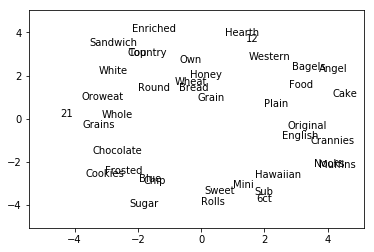

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()

In [ ]:
'''
We have now vectorized the words. 
The data above shows us how related the words are to each other. 
We now need to categorize the product-titles based on the word vectors. K means should be 3. Muffins, Bread, Cookies
What's the theory behind this... Hmmm. Should I have vectorized the sentences from the start?
'''